# 2021-09-10 Some results for a candidate formulation of `oBEo` and `oBEv`

(This is a standalone notebook, not dependent on any other code.)

Considering this as a prime candidate formulation for the behaviour estimation parts of the model:

$$
A_b(k) = \beta_\mathrm{V} \hat{A}_{\mathrm{V},b}(k) + \beta_\mathrm{O} \hat{A}_{\mathrm{O},b}(k)
$$

with $\hat{A}_{\mathrm{V},b} \in [-1, 1]$ the estimated squashed value of behaviour $b$ for the agent in question (low-pass filtered or not), and

$$
\hat{A}_{\mathrm{O},b}(k) = \left( 1 - \frac{\Delta t}{T_\mathrm{Of}} \right) \hat{A}_{\mathrm{O},b}(k-1) + \frac{\Delta t}{T_\mathrm{O1}}\ln{p[\tilde{\mathbf{x}}(k) | b]}
$$

and where the behaviour probabilities are then obtained as:

$$
P_b(k) = \frac{e^{A_b(k)}}{\sum_{b'} e^{A_{b'}(k)}} 
$$

In the handwritten notes dated 2021-09-10 I have derived a number of results for the above formulation, and here I summarise some of these results and test their correctness in simulation.

## Prior probability of a "bad" decision $\rightarrow$ fixing the "temperature" parameter of `oBEv`

In a case where all behaviours have value 0 except behaviour $b_†$ which has the maximally low (squashed) value of -1, we may decide that we want the model to choose $b_†$ with a (low) probability $P_†$. This allows us to fix $\beta_\mathrm{V}$ in terms of this probability (Eqn 3 in the handwritten notes):

$$
\beta_\mathrm{V} = \ln \left( \frac{1}{N_\mathrm{beh}-1} \cdot \frac{1 - P_†}{P_†} \right)
$$

Below just verifying that we indeed get back the intended $P_†$:

In [1]:
import math
import numpy as np
import scipy.special

N_beh = 3
V_bs = np.array((-1, 0, 0))
P_cross = 0.01

# fixing beta_V based on the above
beta_V = math.log((1 / (N_beh-1)) * (1 - P_cross) / P_cross)
print(f'Calculated beta_V = {beta_V:.2f}')

# getting the probabilities of the behaviours
P_bs = scipy.special.softmax(beta_V * V_bs)
print('The estimated probabilities of the three behaviours, using this beta_V, are:')
print(P_bs)

Calculated beta_V = 3.90
The estimated probabilities of the three behaviours, using this beta_V, are:
[0.01  0.495 0.495]


## Evidence dynamics for constant values and observation likelihoods

Without forgetting, i.e., with $T_\mathrm{Of} \rightarrow \infty$, for a fixed $p[\tilde{\mathbf{x}}(k) | b] = p_b$ and fixed value $V_b$ we get the following linear build-up of evidence (Equation 13 in the handwritten notes):

$$
A_b(k) = \beta_\mathrm{V} V_b + \beta_\mathrm{O} k \frac{\Delta t}{T_\mathrm{O1}} \ln p_b
$$

With forgetting, i.e., with a non-infinite $T_\mathrm{Of}$, we instead get (Equation 17 in the handwritten notes):

$$
A_b(k) = \beta_\mathrm{V} V_b + \beta_\mathrm{O} \frac{T_\mathrm{Of}}{T_\mathrm{O1}} \ln p_b \left( 1 - e^{\frac{-k \Delta t }{ T_\mathrm{Of}}} \right)
$$

## Observing different likelihoods but all values the same - just `oBEo`

### Without forgetting

If all the values $V_b$ are equal, and one behaviour $b_*$ has higher likelihood $p_{b_*} = p_\max$ than the other behaviours, which have likelihood $p_\min$, then the time needed to reach a confidence level $P_{b_*} = P_\mathrm{th}$ is (Equation 6 in the handwritten notes):

$$
t = k \Delta t = T_\mathrm{O1} \frac{ \ln{ \left[ (N_\mathrm{beh} - 1) \frac{P_\mathrm{th}}{1 - P_\mathrm{th}} \right] } }{ \ln{ \frac{p_\max}{p_\min} } }
$$

This is confirmed in simulation below:

In theory, should reach P_th = 0.95 at t = 0.815.
Simulation reached P_th = 0.95 at t = 0.900.


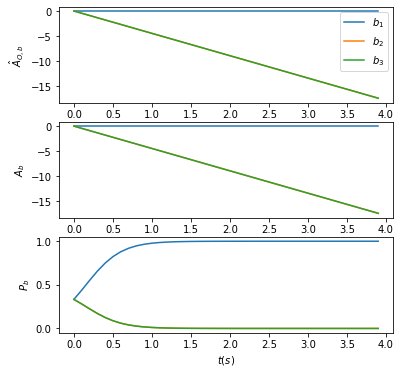

In [2]:
import matplotlib.pyplot as plt

# constants for the current example
p_max = 1
p_min = 0.8
P_th = 0.95

# constants needed for the function below
# - simulation
time_step = 0.1
end_time = 4
# - model parameters
T_Of = math.inf
T_O1 = 0.05
P_cross = 0.01
beta_O = 1
# - behaviour values and observation likelihoods
N_beh = 3
V_bs = np.zeros(3)
p_bs = ((p_max, p_min, p_min))

def beh_estimation_sim():
    beta_V = math.log((1 / (N_beh-1)) * (1 - P_cross) / P_cross)
    time_stamps = np.arange(0, end_time, time_step)
    n_time_stamps = len(time_stamps)
    A_Obs = np.full((n_time_stamps, N_beh), math.nan)
    A_Obs[0, :] = 0
    for i in range(1, n_time_stamps):
        A_Obs[i, :] = (1 - time_step / T_Of) * A_Obs[i-1, :] + (time_step / T_O1) * np.log(p_bs)
    A_bs = beta_V * V_bs + beta_O * A_Obs
    P_bs = scipy.special.softmax(A_bs, axis=1)
    legend = []
    N_PLOTS = 3
    fig, axs = plt.subplots(N_PLOTS, 1, figsize=(6, 6))
    for b in range(N_beh):
        axs[0].plot(time_stamps, A_Obs[:, b])
        axs[1].plot(time_stamps, A_bs[:, b])
        axs[2].plot(time_stamps, P_bs[:, b])
        legend.append(f'$b_{b+1}$')
    axs[0].legend(legend)
    axs[0].set_ylabel('$\hat{A}_{O,b}$')
    axs[1].set_ylabel('$A_b$')
    axs[2].set_ylabel('$P_b$')
    axs[2].set_xlabel('$t (s)$') 
    return (time_stamps, P_bs)

def find_P_th(time_stamps, P_b, P_th):
    samples_above = np.nonzero(P_b >= P_th)
    if len(samples_above[0]) > 0:
        print(f'Simulation reached P_th = {P_th} at t = {time_stamps[samples_above[0][0]]:.3f}.')
    else:
        print(f'Simulation did not reach P_th = {P_th} before t = {time_stamps[-1]:.3f}.')
    
T_th = T_O1 * (math.log( (N_beh-1) * P_th / (1-P_th) )) / ( math.log( p_max / p_min ) )
print(f'In theory, should reach P_th = {P_th} at t = {T_th:.3f}.')

(time_stamps, P_bs) = beh_estimation_sim()
find_P_th(time_stamps, P_bs[:, 0], P_th)

### With forgetting

With a non-infinite $T_\mathrm{Of}$, the time to confidence threshold in this same situation instead becomes (Equation 12 in the handwritten notes):

$$
t = k \Delta t = T_\mathrm{Of} \ln \left( 1 - \frac{ T_\mathrm{O1} \ln{ \left[ (N_\mathrm{beh} - 1) \frac{P_\mathrm{th}}{1 - P_\mathrm{th}} \right] } }{ T_\mathrm{Of} \ln{ \frac{p_\max}{p_\min} } } \right)^{-1}
$$

We see below that the simulation confirms this, and also shows that forgetting slows down the evidence buildup:

In theory, should reach P_th = 0.95 at t = 1.047.
Simulation reached P_th = 0.95 at t = 1.100.


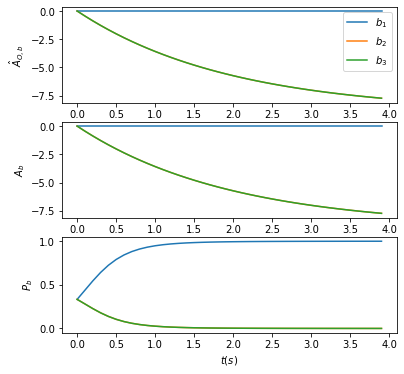

In [3]:
T_Of = 2 # forgetting time constant

T_th_1 =  (1 - (T_O1 * math.log( (N_beh-1) * P_th / (1-P_th) )) / ( T_Of * math.log( p_max / p_min ) ) )
T_th = T_Of * math.log(1/T_th_1)
print(f'In theory, should reach P_th = {P_th} at t = {T_th:.3f}.')

(time_stamps, P_bs) = beh_estimation_sim()
find_P_th(time_stamps, P_bs[:, 0], P_th)

## Observing a "bad" decision - both `oBEv` and `oBEo`

### Without forgetting

Now in a situation where one behaviour $b_†$ is "bad", as described earlier ($V_{b_†} = -1; V_{\lnot b_†} = 0$), but the observed likelihood $p_{b_†} = p_\max$ is larger than $p_{\lnot b_†} = p_\min$, without forgetting we get the following expression for the time at which $P_{b_†} = P_\mathrm{th}$ (Equation 14 in the handwritten notes):

$$
t = k \Delta t = T_\mathrm{O1} \frac{ \ln{ \left( \frac{1 - P_†}{P_†} \frac{P_\mathrm{th}}{1 - P_\mathrm{th}} \right) } }{ \beta_\mathrm{O} \ln{ \frac{p_\max}{p_\min} } }
$$

This is confirmed below. We see how $P_{b_†}$ starts from $P_†$ and then over time overtakes the other two behaviours:

In theory, should reach P_th = 0.95 at t = 1.689.
Simulation reached P_th = 0.95 at t = 1.700.


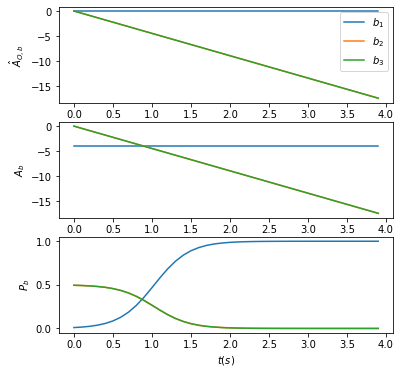

In [4]:
T_Of = math.inf # without forgetting

V_bs = np.array((-1.0, 0.0, 0.0)) 

T_th = T_O1 * (math.log( ((1 - P_cross)/P_cross) * P_th / (1-P_th) )) / ( beta_O * math.log( p_max / p_min ) )
print(f'In theory, should reach P_th = {P_th} at t = {T_th:.3f}.')

(time_stamps, P_bs) = beh_estimation_sim()
find_P_th(time_stamps, P_bs[:, 0], P_th)

### With forgetting

Introducing a non-infinite $T_\mathrm{Of}$, the expression changes to (Equation 19 in the handwritten notes):

$$
t = k \Delta t = T_\mathrm{Of} \ln \left( 1 - \frac{ T_\mathrm{O1} \ln{ \left( \frac{1 - P_†}{P_†} \frac{P_\mathrm{th}}{1 - P_\mathrm{th}} \right) } }{ \beta_\mathrm{O} T_\mathrm{Of} \ln{ \frac{p_\max}{p_\min} } } \right)^{-1}
$$

This is also confirmed below:

In theory, should reach P_th = 0.95 at t = 3.725.
Simulation reached P_th = 0.95 at t = 3.700.


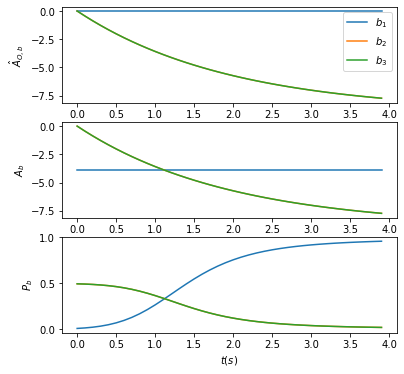

In [5]:
T_Of = 2 # forgetting time constant

T_th_1 = 1 - (T_O1 * math.log( ((1 - P_cross)/P_cross) * P_th / (1-P_th) )) / ( beta_O * T_Of * math.log( p_max / p_min ) )
T_th = T_Of * math.log(1/T_th_1)
print(f'In theory, should reach P_th = {P_th} at t = {T_th:.3f}.')

(time_stamps, P_bs) = beh_estimation_sim()
find_P_th(time_stamps, P_bs[:, 0], P_th)

Note that with forgetting, it is no longer guaranteed that the highest-likelihood behaviour will reach a given confidence threshold, if the value-based "priors" are sufficiently opposed to this belief. For example:

Simulation did not reach P_th = 0.95 before t = 9.900.


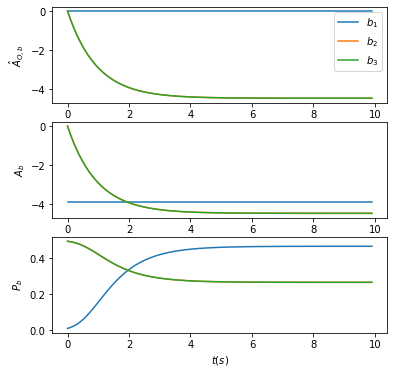

In [6]:
T_Of = 1 # forgetting time constant
end_time = 10

(time_stamps, P_bs) = beh_estimation_sim()
find_P_th(time_stamps, P_bs[:, 0], P_th)

## Summary

My calculations seem to be correct, and I feel like I have a much better grasp on this (candidate) model formulation now; how it works and to some extent also how to parameterise it.

One suggestion for the parameters:

`oBEo`
* Free
    * $T_\mathrm{Of} \in \{ 1, 2, \infty \}$ s
    * $\sigma_\mathrm{O} \in \{ ? \} $ m   (if the model doesn't have observation noise)
* Fixed: 
    * $\beta_\mathrm{O} = 1$
    * $T_\mathrm{O1} = 0.05$ s (or this one might need to become free instead of $\sigma_\mathrm{O}$ if the model has observation noise)

`oBEv`
* Free: 
    * $P_† \in \{0.9, 0.99, 0.999\}$
* Fixed: None really, although the `oBEv` functionality is of course also affected by other things, such as the scaling of the value squashing function
